In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
import sys
from biodatatools.utils.common import json_load
from biodata.delimited import DelimitedWriter
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [4]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

In [5]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import extract_observed_profiles, one_hot_encode

# Examples

In [6]:
s = "HCT116"
ks = ["pl", "mn"]
types = ["wt", "mt"]
motif = "CTCF"

In [7]:
motifs = json_load(f"{PROJECT_DIR_o}FIMO/{s}_CTCF_pos.json")

In [8]:
# Pick examples

regions = [# minTSS - Up
		   "chr2_234881617_234882118",
		   # maxTSS - Down
		   "chr2_233053872_233054373"
		  ]

In [9]:
outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example.bed"
with DelimitedWriter(outputfile) as dw:
	for r in regions:
		chrom, start, end = r.split("_")
		dw.write([chrom, start, end])

# Observed profiles

In [31]:
rpms = {"UT": [f"{PROJECT_DIR_d}Alignments/CTCF_U_5{k}_rpm.bw" for k in ks],
	   "T": [f"{PROJECT_DIR_d}Alignments/CTCF_T_5{k}_rpm.bw" for k in ks],
		}

In [32]:
obs_profs = {}
for k in rpms:
	obs_profs[k] = extract_observed_profiles(rpms[k][0],
		                                    rpms[k][1],
		                                    f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example.bed",
		                                    out_window=500)

== In Extract Profiles ==
Peak filepath: /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example.bed
Profile length: 500
Num. Examples: 2
== In Extract Profiles ==
Peak filepath: /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example.bed
Profile length: 500
Num. Examples: 2


# Predicted profiles

## Get sequences

In [12]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [13]:
def get_sequences(regions, outputfile, fdict, t, motifs):
	seqs = []
	for r in regions:
		chrom, start, end = r.split("_")
		seq = fdict[chrom][int(start)-250:int(end)+249].seq.upper()
		wt_seq = one_hot_encode(seq)
		if t == "wt":
			seqs.append(wt_seq.T)
		else:
			mut_start, mut_end = motifs[r][1:3]
			# in-silico deletion: replace motif instance with [0,0,0,0]
			mt_seq = wt_seq
			for i in range(mut_start-int(start)+250, mut_end-int(start)+250):
				mt_seq[i] = [0,0,0,0]
			seqs.append(mt_seq.T)
	seqs = np.array(seqs)
	np.save(outputfile, seqs)

In [14]:
for t in types:
	outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.npy"
	get_sequences(regions, outputfile, fdict, t, motifs)

## Prediction

In [15]:
script = f"{PROJECT_DIR_s}slurm/predict.sh"
scale = "True"
model_type = "strand_merged_umap"
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.npy"
	output_prefix = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}."
	commands = ["sbatch", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				output_prefix,
				scale,
				str(types.index(t))
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_wt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_wt. True 0
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_mt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_mt. True 1


In [16]:
pred_profs = {}
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.scaled_profiles.npy"
	pred_profs[t] = np.load(inputfile)

## Contribution scores

In [17]:
script = f"{PROJECT_DIR_s}slurm/interpret_any.sh"
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.npy"
	output_prefix = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}."
	commands = ["sbatch", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				output_prefix,
				str(types.index(t))
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/interpret_any.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_wt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_wt. 0
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/interpret_any.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_mt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_CTCF_example_mt. 1


In [18]:
# One-hot scores

scores = {}
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.count_scores.npy"
	scores[t] = np.load(inputfile)

# Browser shots

In [19]:
def plot_PROcap(array, ax):	
    orientations = {"fwd": "#e31a1c", "rev": "#4A4AFF"}
    results = [[i, array[0][i], "fwd"] for i in range(500)]
    results += [[i, -array[1][i], "rev"] for i in range(500)]
    results += [[500, np.nan, "fwd"], [500, np.nan, "rev"]]
    df = pd.DataFrame(results, columns=["position", "reads", "orientation"])
	
    for orientation, color in orientations.items():
        df_orientation = df[df["orientation"] == orientation]
        ax.bar(df_orientation["position"], df_orientation["reads"], color=color, align="edge", width=1)

In [20]:
def plot_scores(array, ax):
	utils.plot_weights(array[:, 250:750], ax)
	ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0), useMathText=True)

In [29]:
def PROcap_contribution_scores(obs_profs, pred_profs, scores, region, color, ylims, yticks, xlims, outputfile):
	nrow = 6
	fig, ax = plt.subplots(nrow, 1, figsize=(5,5.5))

	chrom, start, end = region.split("_")
	m_start = motifs[region][1]-int(start)
	m_end = motifs[region][2]-int(start)
	n = regions.index(region)
	
	for k in range(nrow):
		if k == 0:
			# Observed PROcap signals (UT)
			plot_PROcap(obs_profs["UT"][n], ax[k])
			ylabel = "Obs\n(UT)"
			ax[k].axhline(y=0, ls="--", c="#636363")
		elif k == 1:
			# Observed PROcap signals (T)
			plot_PROcap(obs_profs["T"][n], ax[k])
			ylabel = "Obs\n(T)"
			ax[k].axhline(y=0, ls="--", c="#636363")
		elif k == 2:
			# Predicted PROcap signals (wt)
			plot_PROcap(pred_profs["wt"][n], ax[k])
			ylabel = "Pred\n(wt)"
			ax[k].axhline(y=0, ls="--", c="#636363")
		elif k == 3:
			# Contribution score (wt)
			plot_scores(scores["wt"][n], ax[k])
			ylabel = "Score\n(wt)"
			y = ylims[2]
			ax[k].fill_betweenx(y=y, x1=m_start, x2=m_end, color=color, alpha=0.3)
			ax[k].text(x=m_end+15, y=y[1]*0.5, s=motif, fontsize=bfontsize, color=color)
		elif k == 4:
			# Predicted PROcap signals (mt)
			plot_PROcap(pred_profs["mt"][n], ax[k])
			ylabel = "Pred\n(mt)"
			ax[k].axhline(y=0, ls="--", c="#636363")
		else:
			# Contribution score (mt)
			plot_scores(scores["mt"][n], ax[k])
			ylabel = "Score\n(mt)"
			y = ylims[2]
			ax[k].fill_betweenx(y=y, x1=m_start, x2=m_end, color=color, alpha=0.3)
			ax[k].text(x=m_end+15, y=y[1]*0.5, s="Deletion", fontsize=bfontsize, color=color)
			
		ax[k].set_ylabel(ylabel, fontsize=bfontsize)
		ax[k].yaxis.set_label_coords(-0.12, 0.5)

		ax[k].set_xlim(xlims)
		nticks = (xlims[1]-xlims[0])//100+1
		xticks = [xlims[0]+n*100 for n in range(nticks)]
		# In the center
		ax[k].set_xticks([x+0.5 for x in xticks])
		if k == nrow-1:
			# Genomic coordinates: 1-based
			xticklabels = [int(start)+x+1 for x in xticks]
			ax[k].set_xticklabels(xticklabels)
			ax[k].set_xlabel(f"Genomic position ({chrom})", fontsize=bfontsize)
		else:
			ax[k].set_xticklabels([])
			ax[k].set_xlabel("")

		ax[k].tick_params(labelsize=sfontsize)

	for k in range(nrow):
		# Observed PROcap signals 
		if k in [0,1]:
			ylim = ylims[0]
			ytick = yticks[0]
		# Predicted PROcap signals 
		elif k in [2,4]:
			ylim = ylims[1]
			ytick = yticks[1]
		# Contribution scores
		elif k in [3,5]:
			ylim = ylims[2]
			ytick = yticks[2]
			ax[k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
			
		ax[k].set_ylim(ylim)
		ax[k].set_yticks(ytick)
		
	plt.subplots_adjust(hspace=0.2)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True)

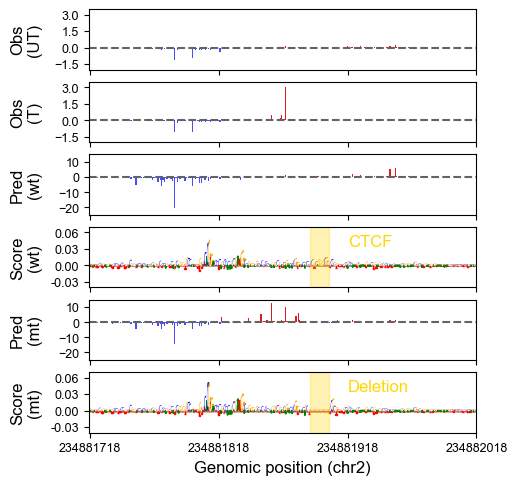

In [33]:
# minTSS - Up

color = "#FFD700"
ylims = [[-2,3.5], [-25,15], [-0.04,0.07]]
yticks = [[-1.5,0,1.5,3], [-20,-10,0,10], [-0.03,0,0.03,0.06]]
xlims = [100,400]
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig12c.png"
PROcap_contribution_scores(obs_profs, pred_profs, scores, regions[0], color, ylims, yticks, xlims, outputfile)

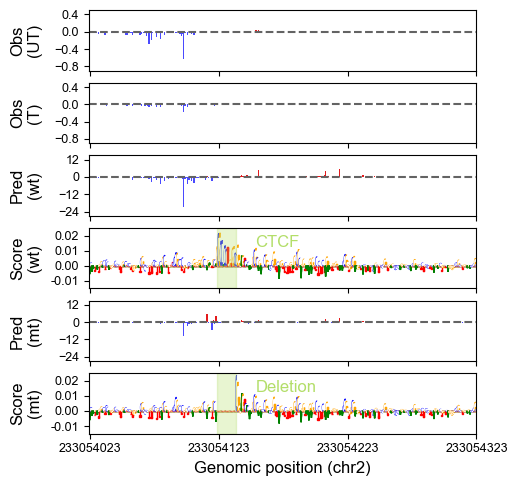

In [34]:
# maxTSS - Down

color = "#b3de69"
ylims = [[-0.9,0.5], [-27,15], [-0.015,0.025]]
yticks = [[-0.8,-0.4,0,0.4], [-24,-12,0,12], [-0.01,0,0.01,0.02]]
xlims = [150,450]
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig12d.png"
PROcap_contribution_scores(obs_profs, pred_profs, scores, regions[1], color, ylims, yticks, xlims, outputfile)